In [1]:
import pandas as pd
pd.set_option('display.max_columns', 999)
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sn
import numpy as np
import itertools as it
import copy
import math
import datetime
import warnings
import scipy.stats as stats
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Features / Columns Names

In [2]:
features={}
features['Classes']  = ["CLASSI_FIN","EVOLUCAO","UTI","DT_ENTUTI","DT_SAIDUTI"]#CLASSI_FIN == typesSRAG | EVOLUCAO == typesEvolucao
features['Dates']    = ["DT_SIN_PRI","DT_INTERNA","DT_EVOLUCA"] 
features['Personal'] = ["CS_SEXO","DT_NASC"]
features['Symptoms'] = ["FEBRE","TOSSE","GARGANTA","DISPNEIA","DESC_RESP","SATURACAO","DIARREIA","VOMITO","DOR_ABD","FADIGA","PERD_OLFT","PERD_PALA","OUTRO_SIN"]
features['RiskF']    = ["PUERPERA","CARDIOPATI","HEMATOLOGI","SIND_DOWN","HEPATICA","ASMA","DIABETES","NEUROLOGIC","PNEUMOPATI","IMUNODEPRE","RENAL","OBESIDADE","OUT_MORBI"]
allFeatures=[]
for f in features.values():
    allFeatures.extend(f)
features['All']      = allFeatures
features['All'].append('HOSPITAL')
#features['All'].append('ID_UNIDADE')
features['All'].extend(["VACINA_COV","DOSE_1_COV","DOSE_2_COV","LAB_PR_COV"])
features['All'].append('SG_UF')#Unidade Federativa de residência do paciente.

## 2021

In [3]:
df_2021_all = pd.read_csv('../datasets/INFLUD21-31-12-2021.csv',sep=";",low_memory=False,usecols=features['All'])

df_2021_all['dateFirstSymptom'] = pd.to_datetime(df_2021_all['DT_SIN_PRI'],format="%d/%m/%Y")
df_2021_all['dateHospitalization'] = pd.to_datetime(df_2021_all[df_2021_all['DT_INTERNA'].notnull()]['DT_INTERNA'],errors = 'coerce',format="%d/%m/%Y")
df_2021_all['dateEvolution'] = pd.to_datetime(df_2021_all[df_2021_all['DT_EVOLUCA'].notnull()]['DT_EVOLUCA'],errors = 'coerce',format="%d/%m/%Y")#Deceased or Recovered
df_2021_all['yearMonth'] = pd.to_datetime(df_2021_all['dateFirstSymptom']).dt.to_period('M')
df_2021_all['ageYearsRoundUp']=2021-pd.to_datetime(df_2021_all['DT_NASC'],format="%d/%m/%Y").dt.year
print('shape all',df_2021_all.shape)
print('shape Covid',df_2021_all[df_2021_all['CLASSI_FIN']==5].shape)
df_2021_all.head()

shape all (1702467, 47)
shape Covid (1177151, 47)


,DT_SIN_PRI,CS_SEXO,DT_NASC,SG_UF,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,HOSPITAL,DT_INTERNA,UTI,DT_ENTUTI,DT_SAIDUTI,CLASSI_FIN,EVOLUCAO,DT_EVOLUCA,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,dateFirstSymptom,dateHospitalization,dateEvolution,yearMonth,ageYearsRoundUp
0,03/01/2021,M,30/08/1941,SP,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,11/01/2021,2.0,NaN,NaN,5.0,1.0,23/01/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-03,2021-01-11,2021-01-23,2021-01,80.0
1,10/01/2021,F,19/06/1973,SP,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,10/01/2021,NaN,NaN,NaN,4.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-10,2021-01-10,NaT,2021-01,48.0
2,05/01/2021,F,27/08/1930,SC,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,08/01/2021,NaN,NaN,NaN,4.0,3.0,12/01/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-05,2021-01-08,2021-01-12,2021-01,91.0
3,09/01/2021,F,16/09/1965,SP,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,9.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13/01/2021,2.0,NaN,NaN,5.0,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2021-01-09,2021-01-13,NaT,2021-01,56.0
4,06/01/2021,F,01/11/1944,SP,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,10/01/2021,2.0,NaN,NaN,4.0,1.0,11/01/2021,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2021-01-06,2021-01-10,2021-01-11,2021-01,77.0


In [4]:
typesSRAG={
    1:'Influenza',
    2:'Outro Vírus',
    3:'Outro Agente',
    4:'Não Sabe',
    5:'COVID-19'
}
for k,v in dict(df_2021_all['CLASSI_FIN'].value_counts()).items():
    print(typesSRAG[k]+':',v)

COVID-19: 1177151
Não Sabe: 354113
Outro Vírus: 18164
Influenza: 7384
Outro Agente: 4745


# COVID Only DF
#### keep only significant months

In [5]:
df_COVID_only = df_2021_all[df_2021_all['CLASSI_FIN']==5]
df_COVID_only = df_COVID_only[(df_COVID_only['yearMonth']>'2020-02') & (df_COVID_only['yearMonth']<'2022-01')]
df_COVID_only.reset_index(drop=True, inplace=True)
print('shape:',df_COVID_only.shape)
df_COVID_only.head()

shape: (1176169, 47)


,DT_SIN_PRI,CS_SEXO,DT_NASC,SG_UF,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,HOSPITAL,DT_INTERNA,UTI,DT_ENTUTI,DT_SAIDUTI,CLASSI_FIN,EVOLUCAO,DT_EVOLUCA,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,dateFirstSymptom,dateHospitalization,dateEvolution,yearMonth,ageYearsRoundUp
0,03/01/2021,M,30/08/1941,SP,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,1.0,11/01/2021,2.0,NaN,NaN,5.0,1.0,23/01/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-03,2021-01-11,2021-01-23,2021-01,80.0
1,09/01/2021,F,16/09/1965,SP,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,9.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13/01/2021,2.0,NaN,NaN,5.0,NaN,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2021-01-09,2021-01-13,NaT,2021-01,56.0
2,05/01/2021,F,07/04/1968,SP,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,09/01/2021,2.0,NaN,NaN,5.0,1.0,15/01/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-05,2021-01-09,2021-01-15,2021-01,53.0
3,09/01/2021,M,17/12/1940,PR,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,11/01/2021,1.0,14/01/2021,18/01/2021,5.0,2.0,18/01/2021,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2021-01-09,2021-01-11,2021-01-18,2021-01,81.0
4,05/01/2021,F,20/06/1958,SP,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,14/01/2021,2.0,NaN,NaN,5.0,1.0,15/01/2021,2.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,2021-01-05,2021-01-14,2021-01-15,2021-01,63.0


# Changing 9 to NAN

In [6]:
columns = list(df_COVID_only.columns)
for feature in columns:
    if(feature !='ageYearsRoundUp'):
        df_COVID_only[feature]=df_COVID_only[feature].replace(9,np.NaN)

# Removing entries without some features

In [7]:
print(df_COVID_only.shape[0])
df_COVID_only=df_COVID_only[df_COVID_only['DT_NASC'].isna()==False]
print(df_COVID_only.shape[0])
df_COVID_only=df_COVID_only[df_COVID_only['dateHospitalization'].isna()==False]
print(df_COVID_only.shape[0])
df_COVID_only=df_COVID_only[df_COVID_only['dateEvolution'].isna()==False]
print(df_COVID_only.shape[0])
df_COVID_only=df_COVID_only[df_COVID_only['HOSPITAL'].isin([1]) & df_COVID_only['EVOLUCAO'].isin([1,2])]
print(df_COVID_only.shape[0])
df_COVID_only=df_COVID_only[df_COVID_only['VACINA_COV'].isin([1,2])]
print(df_COVID_only.shape[0])

1176169
1175521
1116612
990373
988294
535453


In [8]:
df_COVID_only['dataFirstDose'] = pd.to_datetime(df_COVID_only['DOSE_1_COV'],format="%d/%m/%Y",errors='coerce')
df_COVID_only['dataSecondDose'] = pd.to_datetime(df_COVID_only['DOSE_2_COV'],format="%d/%m/%Y",errors='coerce')

# Remove patients who hospitalized before vaccination
I belive some entries were update with vacination information after de hospitalization. I remove these entries.<br>
A vacinação comecou 17/01 e a segunda dose 12/01: https://www.saopaulo.sp.gov.br/noticias-coronavirus/sp-comeca-a-aplicar-segunda-dose-da-vacina-do-butantan-contra-covid-19/

### Overview of these patients

In [9]:
df_COVID_only[(df_COVID_only['dataFirstDose']>df_COVID_only['dateHospitalization'])].head()

,DT_SIN_PRI,CS_SEXO,DT_NASC,SG_UF,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,HOSPITAL,DT_INTERNA,UTI,DT_ENTUTI,DT_SAIDUTI,CLASSI_FIN,EVOLUCAO,DT_EVOLUCA,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,dateFirstSymptom,dateHospitalization,dateEvolution,yearMonth,ageYearsRoundUp,dataFirstDose,dataSecondDose
48,12/01/2021,F,19/08/1944,SP,1.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,17/01/2021,2.0,NaN,NaN,5.0,1.0,20/01/2021,2.0,1.0,2.0,2.0,1.0,15/03/2021,20/04/2021,CORONAVAC,2021-01-12,2021-01-17,2021-01-20,2021-01,77.0,2021-03-15,2021-04-20
60,13/01/2021,M,09/01/1979,MG,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,24/01/2021,NaN,NaN,NaN,5.0,1.0,05/02/2021,NaN,1.0,NaN,NaN,1.0,12/07/2021,04/10/2021,PFIZER,2021-01-13,2021-01-24,2021-02-05,2021-01,42.0,2021-07-12,2021-10-04
90,04/02/2021,M,02/01/1982,SP,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10/02/2021,1.0,10/02/2021,18/02/2021,5.0,1.0,18/02/2021,2.0,2.0,2.0,2.0,1.0,13/07/2021,NaN,ASTRAZENECA,2021-02-04,2021-02-10,2021-02-18,2021-02,39.0,2021-07-13,NaT
108,04/01/2021,M,07/06/1948,SC,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,11/01/2021,1.0,16/01/2021,18/01/2021,5.0,1.0,27/01/2021,NaN,NaN,NaN,NaN,1.0,27/03/2021,24/04/2021,SINOVAC/BUTANTAN,2021-01-04,2021-01-11,2021-01-27,2021-01,73.0,2021-03-27,2021-04-24
187,03/03/2021,F,22/07/1958,CE,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,07/03/2021,NaN,NaN,NaN,5.0,1.0,07/03/2021,2.0,2.0,2.0,2.0,1.0,17/04/2021,24/06/2021,89 - COVID-19-ASTRAZENECA,2021-03-03,2021-03-07,2021-03-07,2021-03,63.0,2021-04-17,2021-06-24


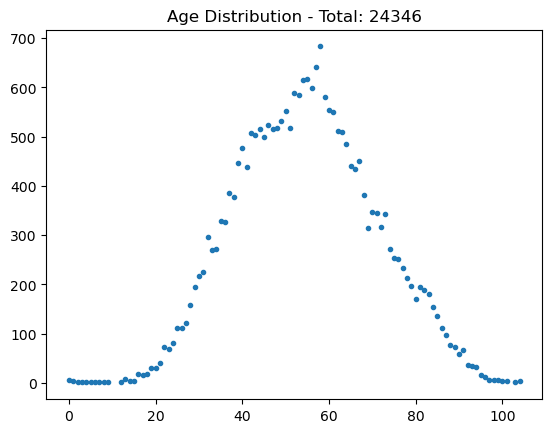

In [10]:
age, amount = zip(*dict(df_COVID_only[
        (df_COVID_only['dataFirstDose']>df_COVID_only['dateHospitalization'])
        | (df_COVID_only['dataSecondDose']>df_COVID_only['dateHospitalization'])
    ]['ageYearsRoundUp'].value_counts()).items())

plt.plot(age,amount,'.')
plt.title("Age Distribution - Total: "+str(sum(amount)))
plt.show()

In [11]:
evolutionDict = dict(df_COVID_only[(df_COVID_only['dataFirstDose']>df_COVID_only['dateHospitalization'])]['EVOLUCAO'].value_counts())
print("Lethality among this group: ",evolutionDict[2]/(evolutionDict[1]+evolutionDict[2])*100)
print("PS: This group in pratic is non-vac since their hospitalization is before the vaccination")

Lethality among this group:  2.8494053926763216
PS: This group in pratic is non-vac since their hospitalization is before the vaccination


In [12]:
evolutionDict = dict(df_COVID_only[(df_COVID_only['dataFirstDose'].isna())]['EVOLUCAO'].value_counts())
print("Lethality non-vac: ",evolutionDict[2]/(evolutionDict[1]+evolutionDict[2])*100)

Lethality non-vac:  32.427947219951164


In [13]:
firstDoseAfterHospitalization=df_COVID_only[(df_COVID_only['dataFirstDose']>df_COVID_only['dateHospitalization'])].index
df_COVID_only.drop(firstDoseAfterHospitalization,inplace=True)
print(df_COVID_only.shape[0])

secondDoseAfterHospitalization=df_COVID_only[(df_COVID_only['dataSecondDose']>df_COVID_only['dateHospitalization'])].index
df_COVID_only.drop(secondDoseAfterHospitalization,inplace=True)
print(df_COVID_only.shape[0])

518467
511107


# Adding more dates and time intervals

In [14]:
df_COVID_only=df_COVID_only.copy()
df_COVID_only['ICUin']=pd.to_datetime(df_COVID_only[df_COVID_only['DT_ENTUTI'].notnull()]['DT_ENTUTI'],errors = 'coerce',format="%d/%m/%Y")
df_COVID_only['ICUout']=pd.to_datetime(df_COVID_only[df_COVID_only['DT_SAIDUTI'].notnull()]['DT_SAIDUTI'],errors = 'coerce',format="%d/%m/%Y")
df_COVID_only["firstSymtonsToHospitalization"]=(df_COVID_only['dateHospitalization']-df_COVID_only['dateFirstSymptom']).dt.days
df_COVID_only["hospitalizationToEvolution"]=(df_COVID_only['dateEvolution']-df_COVID_only['dateHospitalization']).dt.days
df_COVID_only["firstDoseToSymptons"]=(df_COVID_only['dateFirstSymptom']-df_COVID_only['dataFirstDose']).dt.days
df_COVID_only["secondDoseToSymptons"]=(df_COVID_only['dateFirstSymptom']-df_COVID_only['dataSecondDose']).dt.days
df_COVID_only["ICUtime"]=(df_COVID_only['ICUout']-df_COVID_only['ICUin']).dt.days
#Filtering inconsistante dates
df_COVID_only=df_COVID_only[((df_COVID_only['dataFirstDose']>='2021-01-01') & (df_COVID_only['dataFirstDose']<='2021-12-31')) | (df_COVID_only['dataFirstDose'].isna()) ]
df_COVID_only=df_COVID_only[(df_COVID_only['firstDoseToSymptons']>=0) | (df_COVID_only['firstDoseToSymptons'].isna())]
df_COVID_only=df_COVID_only[(df_COVID_only['firstSymtonsToHospitalization']>=0) | (df_COVID_only['firstSymtonsToHospitalization'].isna())]
print(df_COVID_only.shape)
print('Total first dose',df_COVID_only[df_COVID_only['dataFirstDose'].notna()].shape[0])
print('Total second dose',df_COVID_only[df_COVID_only['dataSecondDose'].notna()].shape[0])

(505741, 56)
Total first dose 137370
Total second dose 72053


# Removes patients whose symptoms appeared less than 15 days after the first dose

In [15]:
df_COVID_only.drop(df_COVID_only[df_COVID_only['firstDoseToSymptons']<15].index,inplace=True)
print(df_COVID_only.shape)
print('Total first dose only',df_COVID_only[(df_COVID_only['dataFirstDose'].notna()) & (df_COVID_only['dataSecondDose'].isna())].shape[0])
print('Total second dose (and first)',df_COVID_only[df_COVID_only['dataSecondDose'].notna()].shape[0])
print('Total no dose',df_COVID_only[(df_COVID_only['dataFirstDose'].isna()) & (df_COVID_only['dataSecondDose'].isna())].shape[0])

(475152, 56)
Total first dose only 37366
Total second dose (and first) 71684
Total no dose 366102


In [16]:
37366+71684+366102

475152

# Entries per Month

Total: 475152


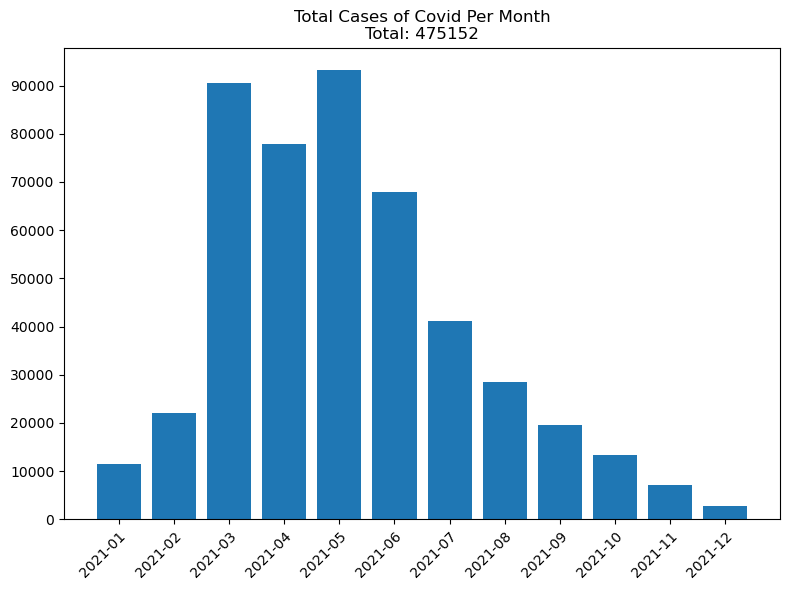

In [17]:
entriesPerMonth=df_COVID_only.groupby(['yearMonth'])['yearMonth'].count()
entriesPerMonth=dict([(t[0].strftime('%Y-%m'),t[1]) for t in entriesPerMonth.items()])

print('Total:',sum(entriesPerMonth.values()))

yearMonthList=list(entriesPerMonth.keys())
xAxis = list(entriesPerMonth.keys())
yAxis = list(entriesPerMonth.values())
plt.figure(figsize=(8,6))
#plt.plot(xAxis,yAxis,'o',linewidth=10)
plt.bar(xAxis,yAxis)
plt.title('Total Cases of Covid Per Month\n'+str('Total: '+str(sum(entriesPerMonth.values()))))
plt.yticks(ticks=np.arange(0,max(yAxis),10000))
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
plt.tight_layout()
#plt.savefig('imgs/Total Cases of Covid Per Month.png',dpi=500)
plt.show()

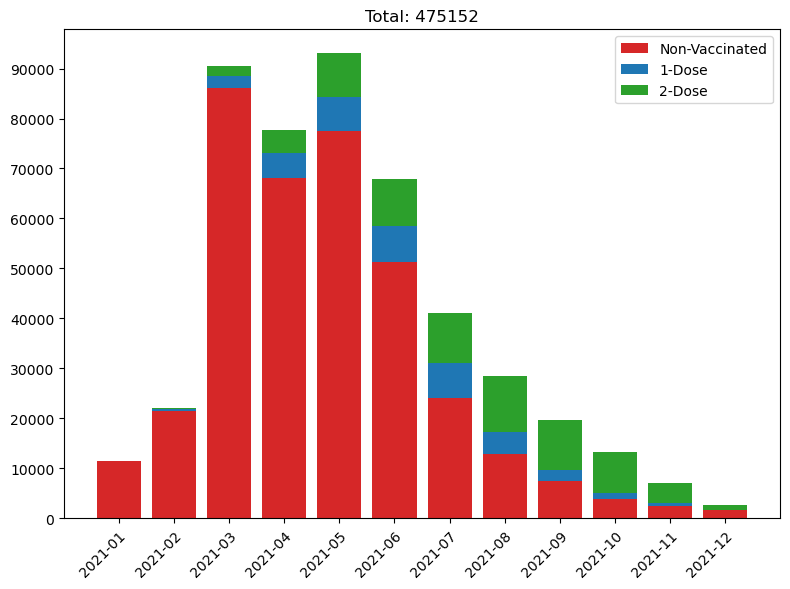

In [18]:
entriesPerMonthVaccine1Dose=dict(df_COVID_only[(df_COVID_only['dataFirstDose'].notna()) & (df_COVID_only['dataSecondDose'].isna())].groupby(['yearMonth'])['yearMonth'].count())
entriesPerMonthVaccine2Dose=dict(df_COVID_only[(df_COVID_only['dataFirstDose'].notna()) & (df_COVID_only['dataSecondDose'].notna())].groupby(['yearMonth'])['yearMonth'].count())
entriesPerMonthNonVaccine=dict(df_COVID_only[df_COVID_only['dataFirstDose'].isna()].groupby(['yearMonth'])['yearMonth'].count())
plt.figure(figsize=(8,6))
y1=list(entriesPerMonthNonVaccine.values())
y2=list(entriesPerMonthVaccine1Dose.values())
y3=list(entriesPerMonthVaccine2Dose.values())

#The 3 list must be the same size. Add 'zero' to others until they are the same size
while len(y2)<len(y1):
    y2.insert(0,0)

while len(y3)<len(y1):
    y3.insert(0,0)

# plot bars in stack 
plt.bar(xAxis, y1, color='tab:red',label="Non-Vaccinated")
plt.bar(xAxis, y2, bottom=y1, color='tab:blue',label="1-Dose")
plt.bar(xAxis, y3, bottom=np.array(y1)+np.array(y2), color='tab:green',label="2-Dose")

#plt.title('Total Cases of Covid Per Month\n'+str('Total: '+str(sum(y1)+sum(y2)+sum(y3))))
plt.title(str('Total: '+str(sum(y1)+sum(y2)+sum(y3))))
plt.yticks(ticks=np.arange(0,plt.ylim()[1],10000))
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
plt.legend()
plt.tight_layout()
plt.savefig('imgs/Total Cases of Covid Per Month VACCINATED VS NON-VACCINATED.png',dpi=200)
plt.show()

## Add Age Group

In [19]:
indexAge = dict(df_COVID_only['ageYearsRoundUp'])
for i in indexAge:
    if(indexAge[i]<10):
        indexAge[i]='<10'
    elif(indexAge[i]>=90):
        indexAge[i]='>90'
    else:
        indexAge[i] = math.floor(indexAge[i]/10)*10
    
df_COVID_only['ageGroup']=pd.DataFrame.from_dict(indexAge,orient='Index')
df_COVID_only['ageGroup'].value_counts()

50     100557
60      87090
40      85117
70      67966
30      55485
80      39107
20      19148
>90     12056
<10      5462
10       3164
Name: ageGroup, dtype: int64

In [20]:
def plotAgeDistribution(dictionary,tit,xlabel,ylabel):
    xAxis=[]
    yAxis=[]
    for a in [10,20, 30, 40, 50, 60, 70, 80, '>90']:
        xAxis.append(str(a))
        yAxis.append(dictionary[a])

    plt.bar(xAxis,yAxis)    
    plt.title(tit,fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)

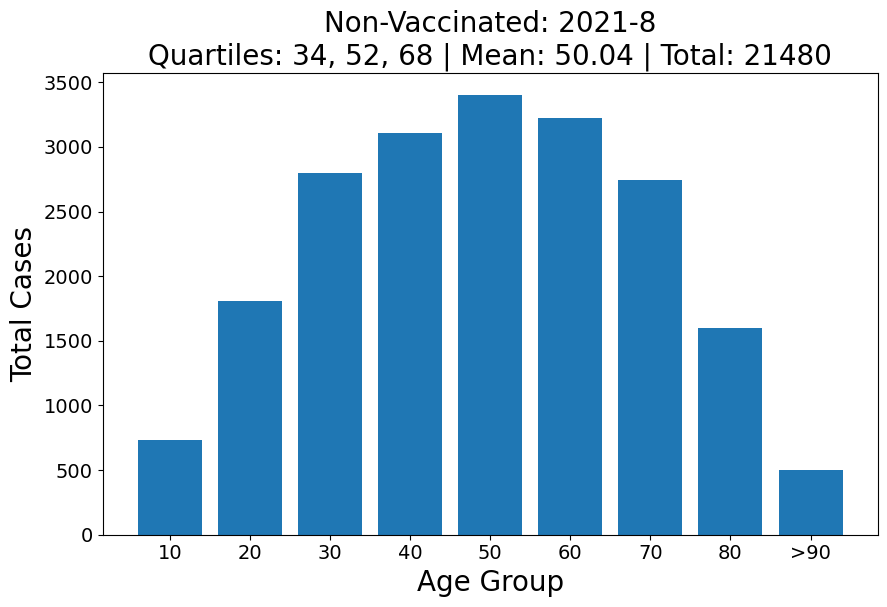

In [21]:
#df = df_COVID_only[df_COVID_only["VACINA_COV"]==1]

#Filtering by date, so we get a time slice with a higher vaccinated group
df = df_COVID_only[(df_COVID_only["VACINA_COV"]==2) & (df_COVID_only['yearMonth']>='2021-8')]

#Info about all Ages
allAges=list(df['ageYearsRoundUp'])
allAges=sorted(allAges)
Q1 = int(np.percentile(allAges,25))
Q2 = int(np.percentile(allAges,50))
Q3 = int(np.percentile(allAges,75))
mean = round(np.mean(allAges),2)

groupAges = list(df['ageGroup'])
#Probability of a certain age be in the dataset
pAge={}
#Get the number of lines in the df that have a 'ageG'
for ageG in groupAges:
    if ageG not in pAge:
        pAge[ageG]=1
    else:
        pAge[ageG]+=1
        
#histogram
plt.subplots(1,1,figsize=(10,6))  
title='Non-Vaccinated: 2021-8\nQuartiles: '+str(Q1)+', '+str(Q2)+', '+str(Q3)+' | Mean: '+str(mean)+' | Total: '+str(len(allAges))
plotAgeDistribution(pAge,title,'Age Group','Total Cases')
plt.savefig('Age Group Distribution - Non-Vaccinated 2021-8.png',dpi=200)
plt.show()


# Entries per Month per Age Group

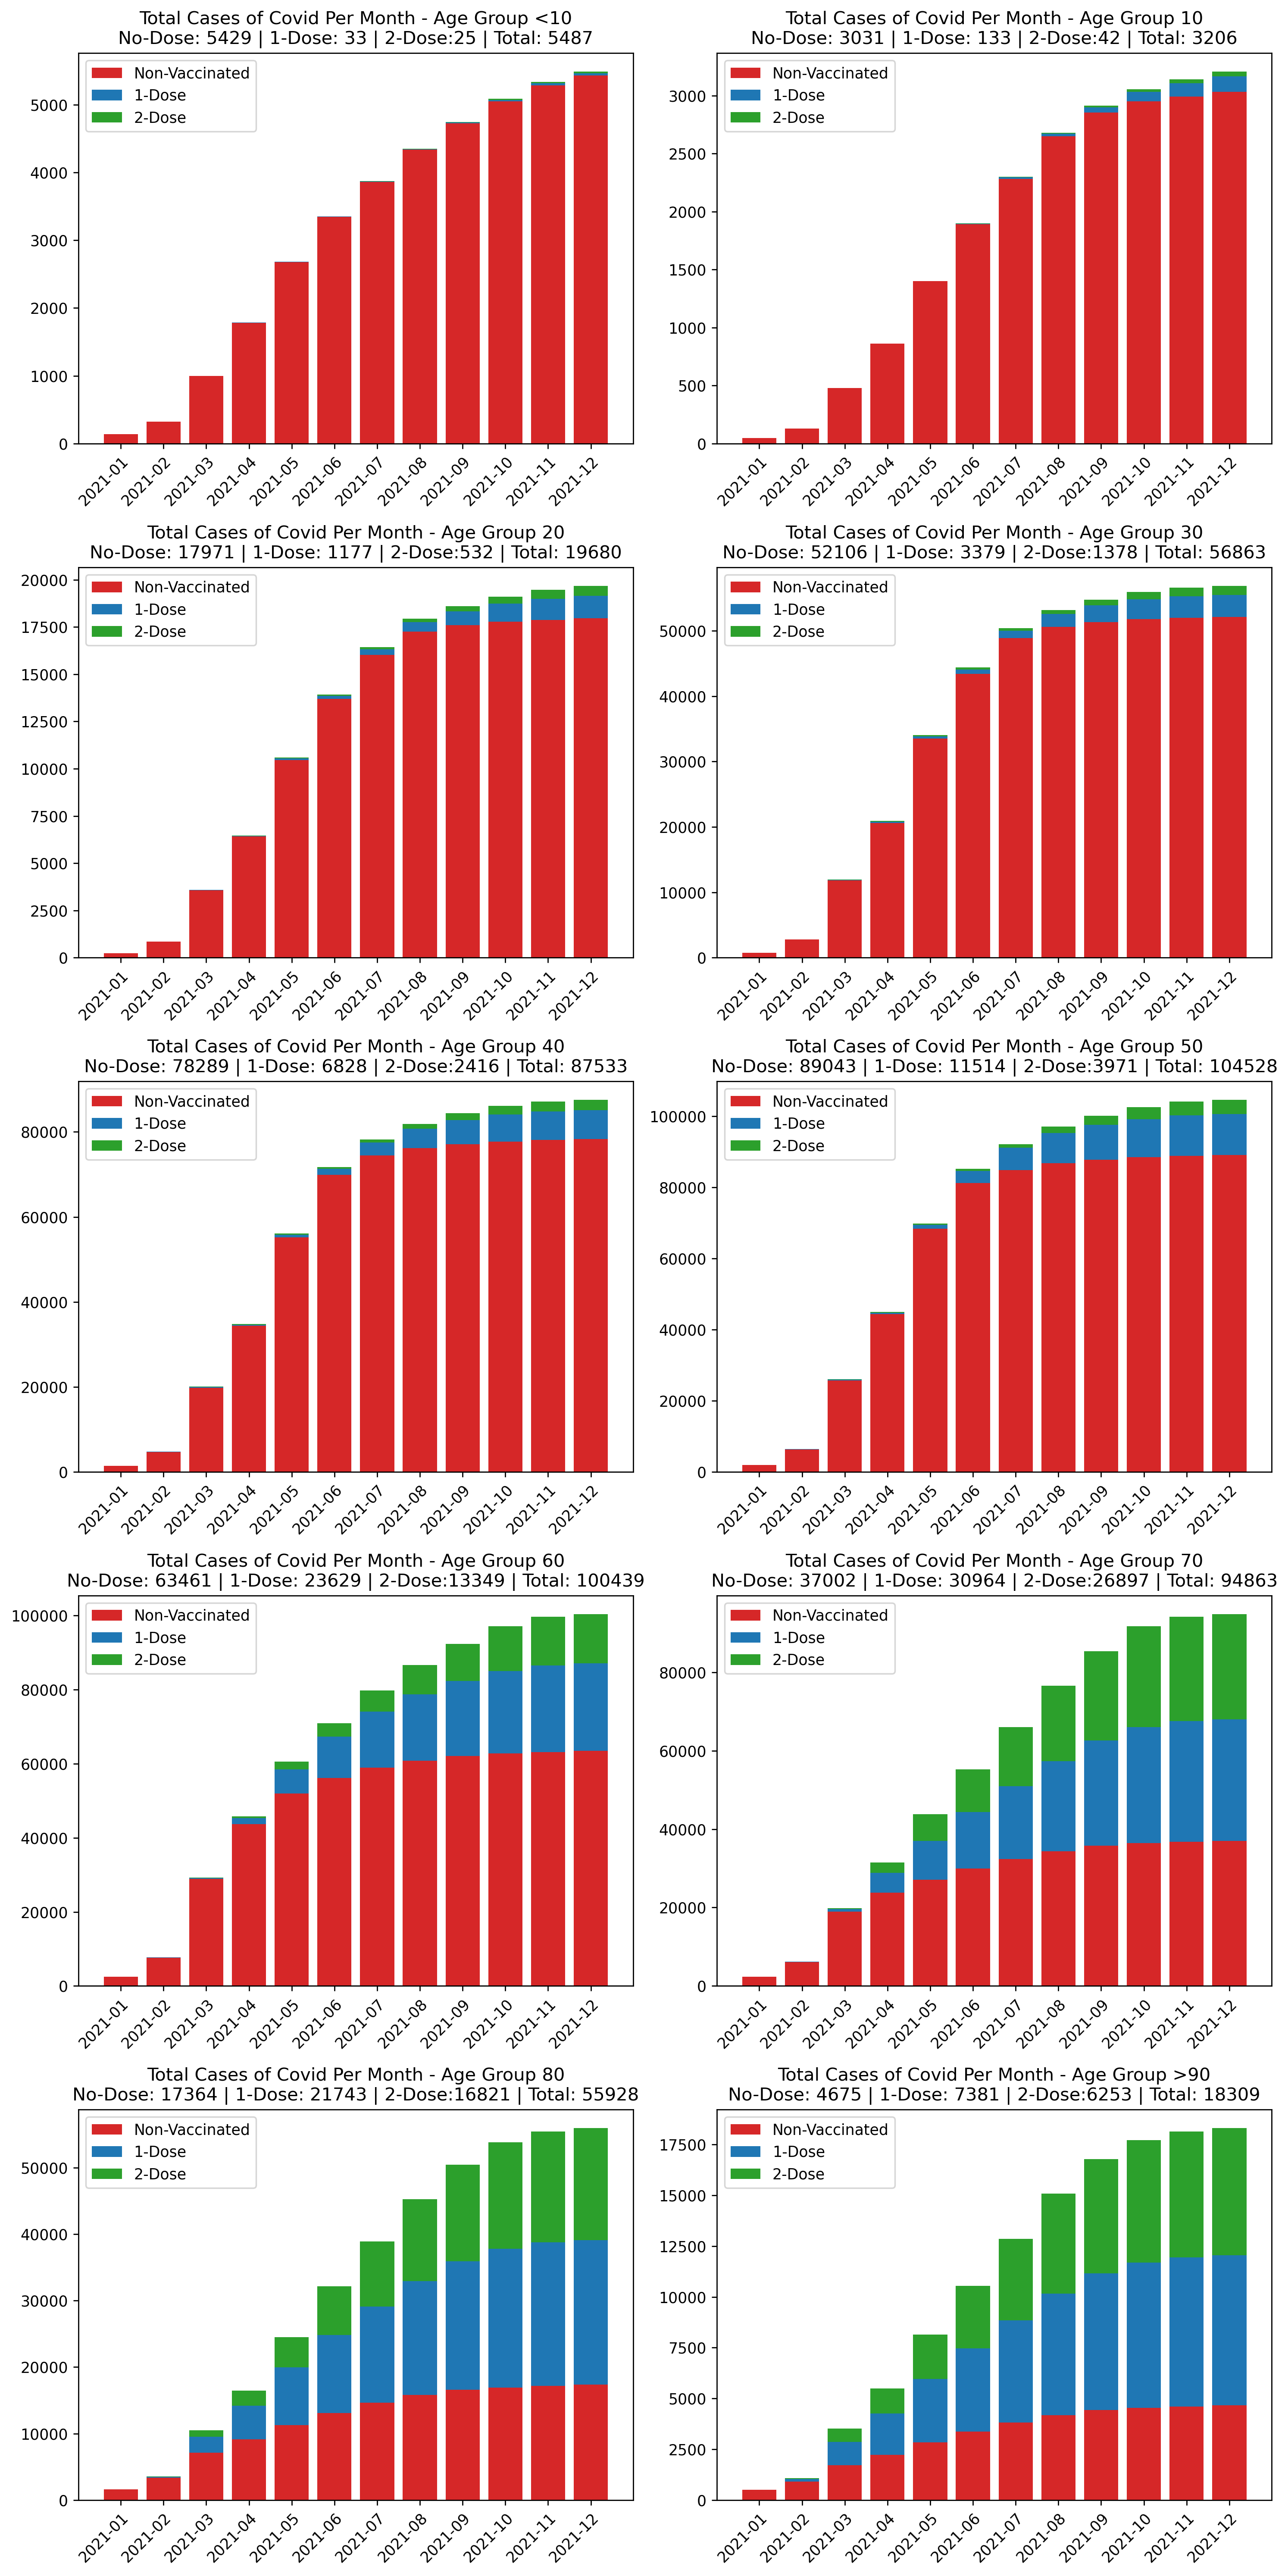

In [22]:

plt.figure(figsize=(12,24),dpi=250) 
degreeCorrOrderList=[]
for i,ageG in enumerate(['<10',10,20,30,40,50,60,70,80,'>90']):
    ax=plt.subplot(5,2,i+1)

    entriesPerMonthVaccine1Dose=dict(df_COVID_only[(df_COVID_only['dataFirstDose'].notna()) & (df_COVID_only['ageGroup']==ageG)].groupby(['yearMonth'])['yearMonth'].count())
    total1Dose=sum(entriesPerMonthVaccine1Dose.values())
    entriesPerMonthVaccine2Dose=dict(df_COVID_only[(df_COVID_only['dataSecondDose'].notna()) & (df_COVID_only['ageGroup']==ageG)].groupby(['yearMonth'])['yearMonth'].count())
    total2Dose=sum(entriesPerMonthVaccine2Dose.values())
    entriesPerMonthNonVaccine=dict(df_COVID_only[(df_COVID_only['dataFirstDose'].isna()) & (df_COVID_only['ageGroup']==ageG)].groupby(['yearMonth'])['yearMonth'].count())
    totalNoDose=sum(entriesPerMonthNonVaccine.values())

    y1=np.cumsum(list(entriesPerMonthNonVaccine.values()))
    y2=np.cumsum(list(entriesPerMonthVaccine1Dose.values()))
    while len(y2)<len(y1):
        y2=np.insert(y2,0,0)
    y3=np.cumsum(list(entriesPerMonthVaccine2Dose.values()))
    while len(y3)<len(y1):
        y3=np.insert(y3,0,0)

    # plot bars in stack 
    plt.bar(xAxis, y1, color='tab:red',label="Non-Vaccinated")
    plt.bar(xAxis, y2, bottom=y1, color='tab:blue',label="1-Dose")
    plt.bar(xAxis, y3, bottom=y1+y2, color='tab:green',label="2-Dose")
    plt.title('Total Cases of Covid Per Month - Age Group '+str(ageG)+'\n'+"No-Dose: "+str(totalNoDose)+" | 1-Dose: "+str(total1Dose)+" | 2-Dose:"+str(total2Dose)+' | Total: '+str(totalNoDose+total1Dose+total2Dose))
    #plt.yticks(ticks=np.arange(0,plt.ylim()[1],1000))
    plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
    plt.legend()
    plt.tight_layout()
    
plt.tight_layout()
plt.savefig('imgs/Total Cases of Covid Per Month VACCINATED VS NON-VACCINATED - Age Group.png',dpi=500)
plt.show()

# Rename Columns

In [23]:
df_COVID_only = df_COVID_only.rename(columns={
             'FEBRE':'FEVER',
             'TOSSE':'COUGH', 
             'GARGANTA':'SORE_THROAT',
             'DISPNEIA':'DYSPNEA', 
             'DESC_RESP':'RESP_DIST', #RESPIRATORY DISTRESS
             'SATURACAO':'SATURATION', 
             'DIARREIA':'DIARRHEA',
             'VOMITO':'VOMIT',
             'OUTRO_SIN':'OTHER_SYMP',#OTHER SYMPTOMS
             'DOR_ABD':'ABD_PAIN',#abdominal pain
             'FADIGA':'FATIGUE', 
             'PERD_OLFT':'SMELL_LOSS',
             'PERD_PALA':'TASTE_LOSS'
            })

# Symptons over time

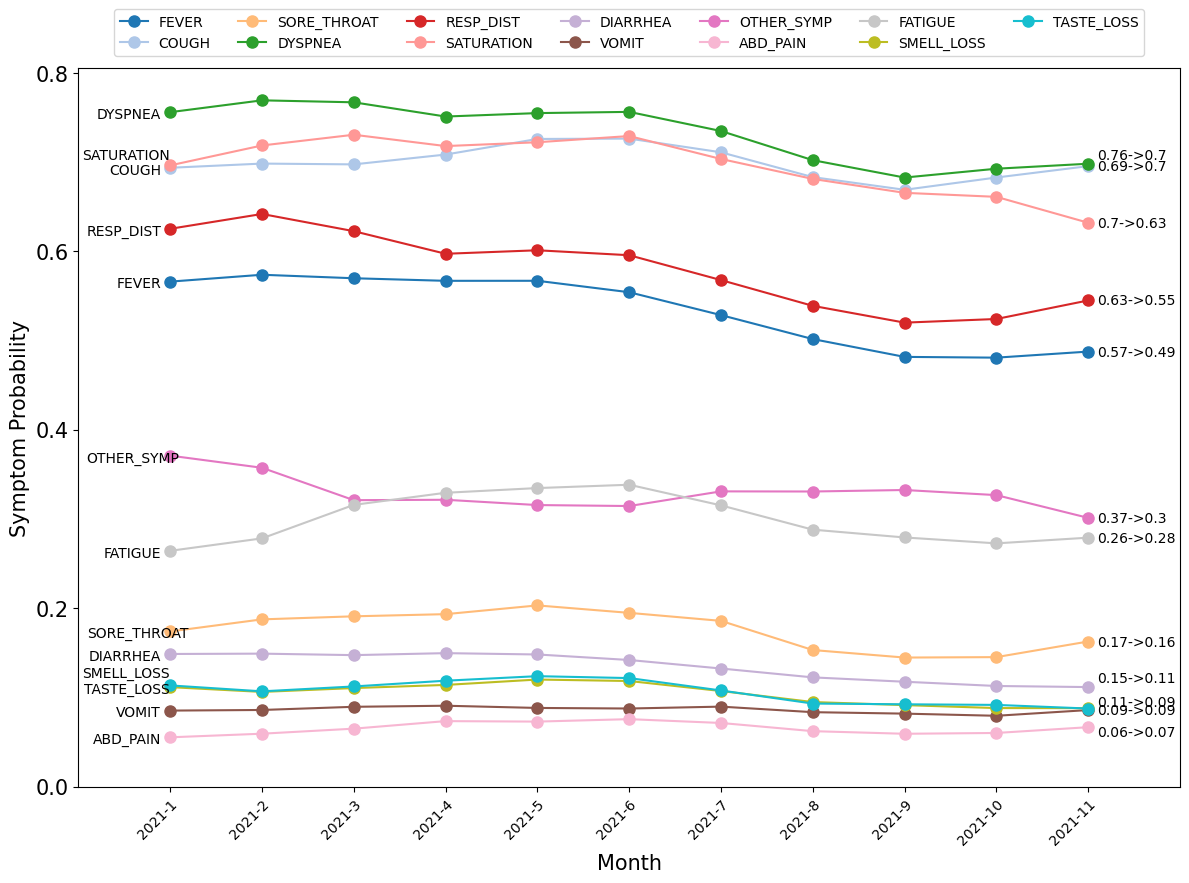

In [24]:
symptoms=['FEVER','COUGH','SORE_THROAT','DYSPNEA','RESP_DIST','SATURATION','DIARRHEA','VOMIT','OTHER_SYMP','ABD_PAIN','FATIGUE','SMELL_LOSS','TASTE_LOSS']
df=df_COVID_only
#Get the months
months = sorted(set(df['yearMonth']))
#Remove dezember because its has few data
months=months[:-1]

#For Plotting
fig, ax = plt.subplots(1,1,figsize=(12,9))
NUM_COLORS = len(symptoms)
cm = plt.get_cmap('tab20')
ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
resultsDict={}
for symp in symptoms:
    xAxis=[]
    yAxis=[]
    for month in months:

        #filter the complete DF per month
        df_month = df[df['yearMonth']==month][symp]

        sympValues = list(df_month)
        #Dict for amount patient that survive (1) or not survive (2) in the current AgeGroup
        sympProb={1:0,2:0}
        for e in sympValues:
            if(e==1):
                sympProb[1]+=1
            elif(e==2):
                sympProb[2]+=1

        sympProb[1]=sympProb[1]/len(sympValues)
        sympProb[2]=sympProb[2]/len(sympValues)
        #The Plot is about Suvival
        yAxis.append(sympProb[1])
        xAxis.append(month)
        
    #Transform from 'period' to string like '2021-01'
    xAxis=[str(date.year)+'-'+str(date.month) for date in xAxis]
    
    resultsDict[symp]=yAxis
    
    plt.plot(xAxis,yAxis,marker="o",fillstyle='full',markersize=8) 
    plt.tight_layout()
    #Manual setting os labels
    if(symp == "OTHER_SYMP"):        
        ax.text(0.1, yAxis[0]-0.007, symp, ha='right')
    elif(symp == "SORE_THROAT"):        
        ax.text(0.2, yAxis[0]-0.007, symp, ha='right')
    elif(symp == "SATURATION"):        
        ax.text(0, yAxis[0]+0.007, symp, ha='right')
        
    elif(symp == "SMELL_LOSS"):        
        ax.text(0.0, yAxis[0]-0.007, "SMELL_LOSS\nTASTE_LOSS", ha='right')    
    elif(symp=="TASTE_LOSS"):
        ax.text(0.0, yAxis[0]-0.007, '', ha='right')
    else:
        ax.text(-0.1, yAxis[0]-0.007, symp, ha='right')
        

    if(symp=='DIARRHEA'):
        ax.text(len(months)-0.90, yAxis[-1]+0.005, str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')   
    elif(symp=="TASTE_LOSS"):
        ax.text(len(months)-0.90, yAxis[-1]+0.002, str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')
    elif(symp=="SMELL_LOSS"):
        ax.text(len(months)-0.90, yAxis[-1], '', ha='left')
    elif(symp=='VOMIT'):
        ax.text(len(months)-0.90, yAxis[-1]-0.005,str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')
    elif(symp=='ABD_PAIN'):
        ax.text(len(months)-0.90, yAxis[-1]-0.01,str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')

    elif(symp=='DYSPNEA'):
        ax.text(len(months)-0.90, yAxis[-1]+0.005, str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')
    elif(symp=='COUGH'):
        ax.text(len(months)-0.90, yAxis[-1]-0.005, str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')    
    else:
        ax.text(len(months)-0.90, yAxis[-1]-0.005, str(round(yAxis[0],2)) +'->'+str(round(yAxis[-1],2)), ha='left')
    ax.margins(x=0.1)



#plt.title(symp+str(df_month.shape[0])+'\n ', fontsize=19,y=1.05)
plt.xlabel('Month',fontsize=15)
plt.xticks(rotation=45,ha='right', rotation_mode='anchor')
plt.legend(symptoms,bbox_to_anchor=(0.5, 1.05), loc='center',ncol=int(len(symptoms)/2)+1)
plt.yticks(ticks=np.arange(0,1,0.2),fontsize=15)
plt.ylabel('Symptom Probability',fontsize=15)
#plt.title("Total Patients:"+str(df[df['yearMonth'].isin(months)].shape[0])+'\n ', fontsize=19,y=1)
plt.tight_layout()
plt.savefig('SymptonsOverTime all.png',dpi=200)
plt.show()

In [25]:
pd.DataFrame(resultsDict,index=xAxis).T

,2021-1,2021-2,2021-3,2021-4,2021-5,2021-6,2021-7,2021-8,2021-9,2021-10,2021-11
FEVER,0.566195,0.573888,0.569977,0.567088,0.567128,0.554307,0.528675,0.501797,0.481819,0.480966,0.487763
COUGH,0.693810,0.698514,0.697617,0.708619,0.726110,0.726510,0.711161,0.683343,0.669125,0.682892,0.695646
SORE_THROAT,0.174060,0.187596,0.191017,0.193440,0.203237,0.194892,0.185917,0.153220,0.144790,0.145275,0.162777
DYSPNEA,0.756142,0.769412,0.767196,0.751244,0.755105,0.756466,0.735006,0.702332,0.682856,0.692748,0.698349
RESP_DIST,0.625402,0.642022,0.622742,0.597408,0.601329,0.595798,0.567921,0.539036,0.520216,0.524300,0.545105
SATURATION,0.696501,0.718809,0.730836,0.718134,0.722429,0.729379,0.703667,0.681299,0.665717,0.661225,0.632186
DIARRHEA,0.148798,0.149180,0.147505,0.149734,0.148240,0.142056,0.132509,0.122569,0.117683,0.112925,0.111696
VOMIT,0.085337,0.086029,0.089589,0.090792,0.088306,0.087661,0.089783,0.083568,0.081931,0.079522,0.085942
OTHER_SYMP,0.371126,0.357525,0.321221,0.321649,0.315731,0.314643,0.331079,0.330926,0.332604,0.326888,0.301366
ABD_PAIN,0.055387,0.059436,0.065091,0.073536,0.073004,0.075744,0.071462,0.062289,0.059350,0.060262,0.066733


# Symptons Network

In [26]:
def plotGraph(G,nodeFrequency,nameS=''):
    # pos=nx.kamada_kawai_layout(G,weight=None)
    pos={
        'SATURATION':[-.9, -.50],
        'DYSPNEA': [-0.9, 0.25],
        'RESP_DIST':[-0.65, -0.15],

        'COUGH':    [-0.5, 0.7],       
        'FEVER':    [-0.2, 0.6],
        'SORE_THROAT': [0., 0.9], 

        'SMELL_LOSS':[-0.5, -0.9],
        'TASTE_LOSS':[0.82, -0.95],    
        'FATIGUE':   [0., -0.55],

        'VOMIT':   [0.7, 0.5],
        'ABD_PAIN':  [0.9, -0.5],
        'DIARRHEA': [0.15, 0.25]

    }

    plt.figure(figsize=(8,8))    
    edge_labels=nx.get_edge_attributes(G,name='weight')  
    edgeWidth = [np.log2(x)*3 for x in list(edge_labels.values())]
    #Coloring by frequence
    measure = [nodeFrequency[key] for key in G.nodes] 
    vmin = min(measure)
    vmax = max(measure)
    cmap = plt.cm.Wistia
    #map = plt.cm.viridis_r
    nx.draw(G, pos, with_labels=True,node_size=3000,font_size=9.5,font_color='black', width=edgeWidth,edge_color='gray',node_color=measure,cmap=cmap, vmin=vmin, vmax=vmax)
    #nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
    plt.title(G.name)
    plt.xlim((-1., 1.))
    plt.ylim((-1.1, 1.))

    #cmap Bar
    ax=plt.gca()
    axins = inset_axes(ax,
                       width="3%",
                       height="100%", 
                       loc='lower left',
                       bbox_to_anchor=(1.01, 0., 1, 1),
                       bbox_transform=ax.transAxes,
                       borderpad=0
                       )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    #Set the bar ticks print(vmin,vmax)
    dif=vmax-vmin
    oneThird=dif/4
    ticks=[vmin]
    ticks.extend([int(oneThird*x)+vmin for x in range(1,5)])
    cbar=plt.colorbar(sm,cax=axins,ticks=ticks)
    labels=[str(tick)[:-3]+'K' for tick in ticks]
    cbar.ax.set_yticklabels(labels)

    #Set the space, so the plot dont cut the vertices
    name=G.name+"Network.png"
    plt.tight_layout()
    plt.savefig("imgs/Symptons Network "+nameS,dpi=200)
    plt.show()


def OddsRatioMain(A_label,B_label,neither,AnotB,BnotA,both,complete=False):
    returnDict={}
    returnDict['A']=A_label
    returnDict['B']=B_label
    returnDict['Neither']=neither
    returnDict['AnotB']=AnotB
    returnDict['BnotA']=BnotA
    returnDict['Both']=both

    #chi2, pChi, dof, ex = stats.chi2_contingency([[both, AnotB], [BnotA, neither]])
    oddsratio,pFisherTwoSided = stats.fisher_exact([[both, AnotB], [BnotA, neither]],alternative='two-sided')
    returnDict['OR']=round((oddsratio),3)

    if(oddsratio<1):
        oddsratio,pFisherLess = stats.fisher_exact([[both, AnotB], [BnotA, neither]],alternative='less')
        returnDict['p-value']=round(pFisherLess,3)
    elif(oddsratio>1):    
        oddsratio,pFisherGreater = stats.fisher_exact([[both, AnotB], [BnotA, neither]],alternative='greater')
        returnDict['p-value']=round(pFisherGreater,3)
    else:
        returnDict['p-value']=round(pFisherTwoSided,3)

    total=neither+AnotB+BnotA+both
    if(total<=0):
        return None       
    else:
        pA = (AnotB+both)/total
        pB = (BnotA+both)/total
        expectedByChance=pA*pB*total
        returnDict['pA']=round(pA,2)
        returnDict['pB']=round(pB,2)
        returnDict['expectedByChance(EBC)']=int(expectedByChance)
        returnDict['Both/EBC-1']=round(returnDict['Both']/returnDict['expectedByChance(EBC)']-1,2)
        return returnDict
        
def oddsRatioDF(A,B,df_param):
    neither=df_param[(df_param[A]==2)&(df_param[B]==2)].shape[0]
    both   =df_param[(df_param[A]==1)&(df_param[B]==1)].shape[0] 
    AnotB  =df_param[(df_param[A]==1)&(df_param[B]==2)].shape[0] 
    BnotA  =df_param[(df_param[A]==2)&(df_param[B]==1)].shape[0] 
    return OddsRatioMain(A,B,neither,AnotB,BnotA,both)

def edgeWeightAnalisisHeatmapDistribution(G,title,name):    
    orValues = list(nx.get_edge_attributes(G,'weight').values())

    fig, axes = plt.subplots(1, 2, figsize=(15,8))
    fig.suptitle(title,fontsize=22)

    #=======Heatmap
    df = nx.to_pandas_adjacency(G)
    np.fill_diagonal(df.values,np.nan)
    axes[0].invert_yaxis()
    axes[0].xaxis.tick_top()
    axes[0].set_title('AdjacencyMatrix')
    sn.heatmap(df, annot=True,cmap='magma_r',linewidths=1,fmt='.3g',vmin=0,vmax=5,ax=axes[0])

    #=======Distribution Plot
    #Here a remove the biggest value, for scale
    orValues.remove(max(orValues))

    Q1 = round(np.percentile(orValues,25),2)
    Q2 = round(np.percentile(orValues,50),2)
    Q3 = round(np.percentile(orValues,75),2)
    mean = round(np.mean(orValues),2)

    axes[1].plot(sorted(orValues),'.',color='blue')
    #Quatiles lines
    axes[1].axhline(y=1, color='gray', linestyle='--',linewidth=1)

    axes[1].set_title('Odds Ratio Values \n Quartiles: '+str(Q1)+', '+str(Q2)+', '+str(Q3)+' | Mean:'+str(mean))
    plt.tight_layout()
    plt.savefig("imgs/Symptons Network Edge Heatmap"+name,dpi=200)
    plt.show()
    
def edgeWeightAnalisisHeatmap(G,title):    
    orValues = list(nx.get_edge_attributes(G,'weight').values())

    fig, axes = plt.subplots(1, 1, figsize=(8,8))
    plt.title(title,fontsize=22)

    #=======Heatmap
    df = nx.to_pandas_adjacency(G)
    np.fill_diagonal(df.values,np.nan)
    axes.invert_yaxis()
    axes.xaxis.tick_top()
    sn.heatmap(df, annot=True,cmap='magma_r',linewidths=1,fmt='.3g',vmin=0,vmax=5)

    plt.tight_layout()
    plt.show()

Df lines: 475152


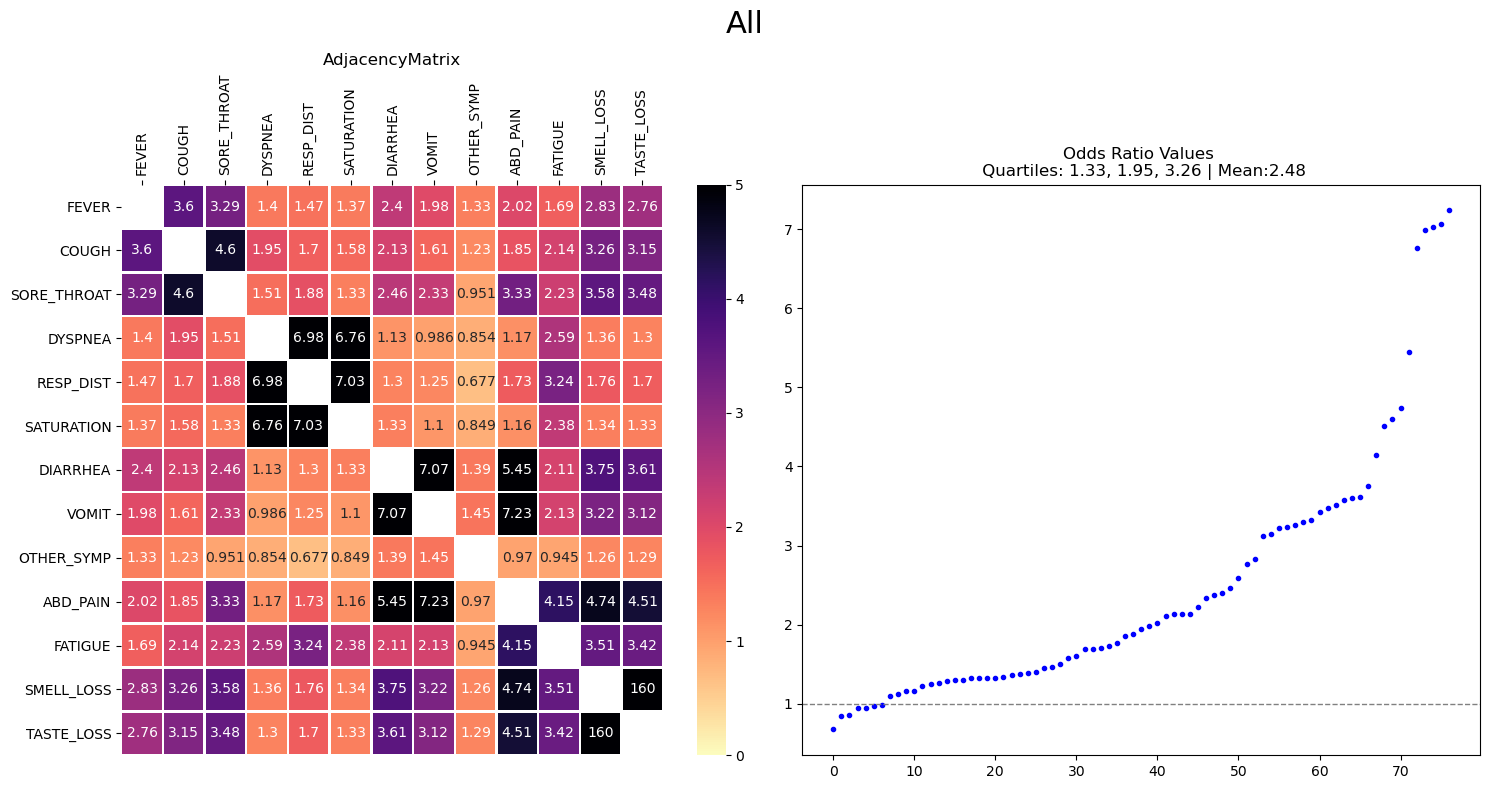

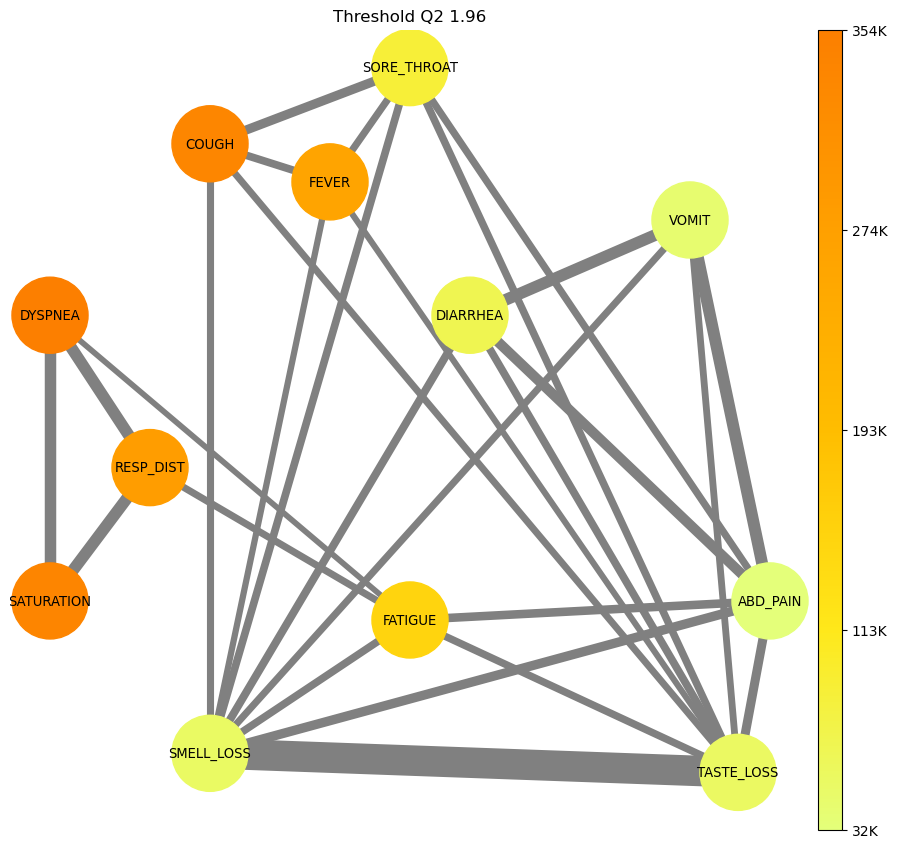

In [27]:
df_param=df_COVID_only
name=' Network of Co-occurring Symptoms.'

print('Df lines:',df_param.shape[0])
totalOccurrencePerSymptom={}
for symp in symptoms:
    totalOccurrencePerSymptom[symp]=df_param[df_param[symp]==1].shape[0]
#Calculate the OddsRatio
oddsRatioMatrix={}
for i,pair in enumerate(it.combinations(symptoms,2)):
    oddsRatioMatrix[i]=oddsRatioDF(*pair,df_param)

oddsRatioDf=pd.DataFrame.from_dict(oddsRatioMatrix,orient='index')

#Create the Network
G_all = nx.Graph()
G_threshold = nx.Graph()
G_threshold.name='Threshold Q2'
relatedOR = [v for v in oddsRatioDf['OR']]
Q2 = round(np.percentile(relatedOR,50),2)
G_threshold.name='Threshold Q2 '+str(Q2)
for k in oddsRatioMatrix:
    v1=oddsRatioMatrix[k]['A']
    v2=oddsRatioMatrix[k]['B']    
    w =oddsRatioMatrix[k]['OR'] 
    G_all.add_edge(v1,v2,weight=w)
    w=round(w,2)
#     if(w>Q2):
#         G_threshold.add_edge(v1,v2,weight=w)
    if(w>2.5):
        G_threshold.add_edge(v1,v2,weight=w)


edgeWeightAnalisisHeatmapDistribution(G_all,'All',name)
plotGraph(G_threshold,totalOccurrencePerSymptom,name)


# Values used to explain the approuch

In [35]:
total = df_param.shape[0]
saturation = df_param[df_param['SATURATION']==1].shape[0]
dyspena = df_param[df_param['DYSPNEA']==1].shape[0]
smellLoss = df_param[df_param['SMELL_LOSS']==1].shape[0]
print(total,saturation,dyspena,smellLoss)
print(round(saturation/total*100),round(dyspena/total*100),round(smellLoss/total*100))

475152 338931 354765 52635
71 75 11


In [37]:
saturationDyspnea = df_param[(df_param['SATURATION']==1) & (df_param['DYSPNEA']==1)].shape[0]
saturationSmellLoss = df_param[(df_param['SATURATION']==1) & (df_param['SMELL_LOSS']==1)].shape[0]
saturationDyspnea,saturationSmellLoss

(283660, 39049)

#### saturation and dyspnea

In [41]:
df_param[(df_param['SATURATION']==1) & (df_param['DYSPNEA']==1)].shape[0],df_param[(df_param['SATURATION']==1) & (df_param['DYSPNEA']==2)].shape[0],df_param[(df_param['SATURATION']==2) & (df_param['DYSPNEA']==1)].shape[0],df_param[(df_param['SATURATION']==2) & (df_param['DYSPNEA']==2)].shape[0]

(283660, 38109, 44774, 40663)

In [42]:
((283660/38109) / (44774/40663))

6.759959084292124

#### saturation and smell loss

In [43]:
df_param[(df_param['SATURATION']==1) & (df_param['SMELL_LOSS']==1)].shape[0],df_param[(df_param['SATURATION']==1) & (df_param['SMELL_LOSS']==2)].shape[0],df_param[(df_param['SATURATION']==2) & (df_param['SMELL_LOSS']==1)].shape[0],df_param[(df_param['SATURATION']==2) & (df_param['SMELL_LOSS']==2)].shape[0]

(39049, 223159, 9802, 74837)

In [44]:
((39049/223159) / (9802/74837))

1.335971462503855

# Number Of NaN per Feature

In [28]:
def plotDfValues(df,name=''):
    #df=df.drop(columns=['ageYearsRoundUp','',axis=1)
    columns = list(df.columns)

    #Fixed the number of columns and calculate number of lines 
    cols = 5
    lines=math.ceil((len(columns)-2)/cols)
    fig, ax = plt.subplots(lines,cols,figsize=(15, 23),dpi=200)
    l,c = 0,0

    #Calculate the number of values for each feature
    for feature in columns:
        if feature not in ['ageYearsRoundUp','yearMonth']:
            months={}
            for ym in yearMonthList:
                month_df = df[df['yearMonth']==ym]

                months[ym]={}
                months[ym]['nan']=len(month_df[month_df[feature].isnull()][feature])
                months[ym]['others']=len(month_df[feature])-months[ym]['nan']
                months[ym]['one']=len(month_df[month_df[feature]==1][feature])
                months[ym]['two']=len(month_df[month_df[feature]==2][feature])
                months[ym]['nine']=len(month_df[month_df[feature]==9][feature])

            nan = [months[k]['nan'] for k in months ]
            one = [months[k]['one'] for k in months ]
            two = [months[k]['two'] for k in months ] 
            nine= [months[k]['nine'] for k in months ]
            others= [months[k]['others'] for k in months ]

            ind = np.arange(len(nan)) 

            #Start Ploting
            plt.sca(ax[l,c])
            #plt.subplots(figsize =(8, 5))
            if(feature != 'CS_RACA' and (sum(one)>0 or sum(two)>0)):
                p1 = ax[l,c].bar(ind, one,color='tab:blue')
                p2 = ax[l,c].bar(ind, two, bottom = one,color='tab:orange')                        
                yPosition = [i+j for i,j in zip(one,two)]
            else:
                p5 = ax[l,c].bar(ind, others,color='tab:green')        
                yPosition = [i for i in others]        
            p3 = ax[l,c].bar(ind, nine,bottom = yPosition,color='black')
            yPosition = [i+j for i,j in zip(yPosition,nine)]
            p4 = ax[l,c].bar(ind, nan, bottom = yPosition,color='tab:red')
            ax[l,c].set_title(feature)
            ax[l,c].set_xticklabels(list(months.keys()),rotation=90,fontsize=6)
            c+=1
            if(c==cols):
                c=0
                l+=1

    plt.setp(ax, xticks=ind, xticklabels=list(months.keys()))
    
    #plt.legend(bbox_to_anchor=(x0, y0, width, height), loc=)
    fig.legend((p1[0], p2[0],p3[0],p4[0],p5[0]), ('Yes', 'No','Ignored','Null','Others'),bbox_to_anchor=(0.13, 1.02), loc='center',ncol = 5)
    fig.suptitle("Values in Dataset\n"+str(df.shape[0]), fontsize=19,y=1.05)
    plt.tight_layout()
    plt.savefig('imgs/Values In Dataset '+name+'.png', 
                dpi=500, 
                format='png')    
    plt.show()

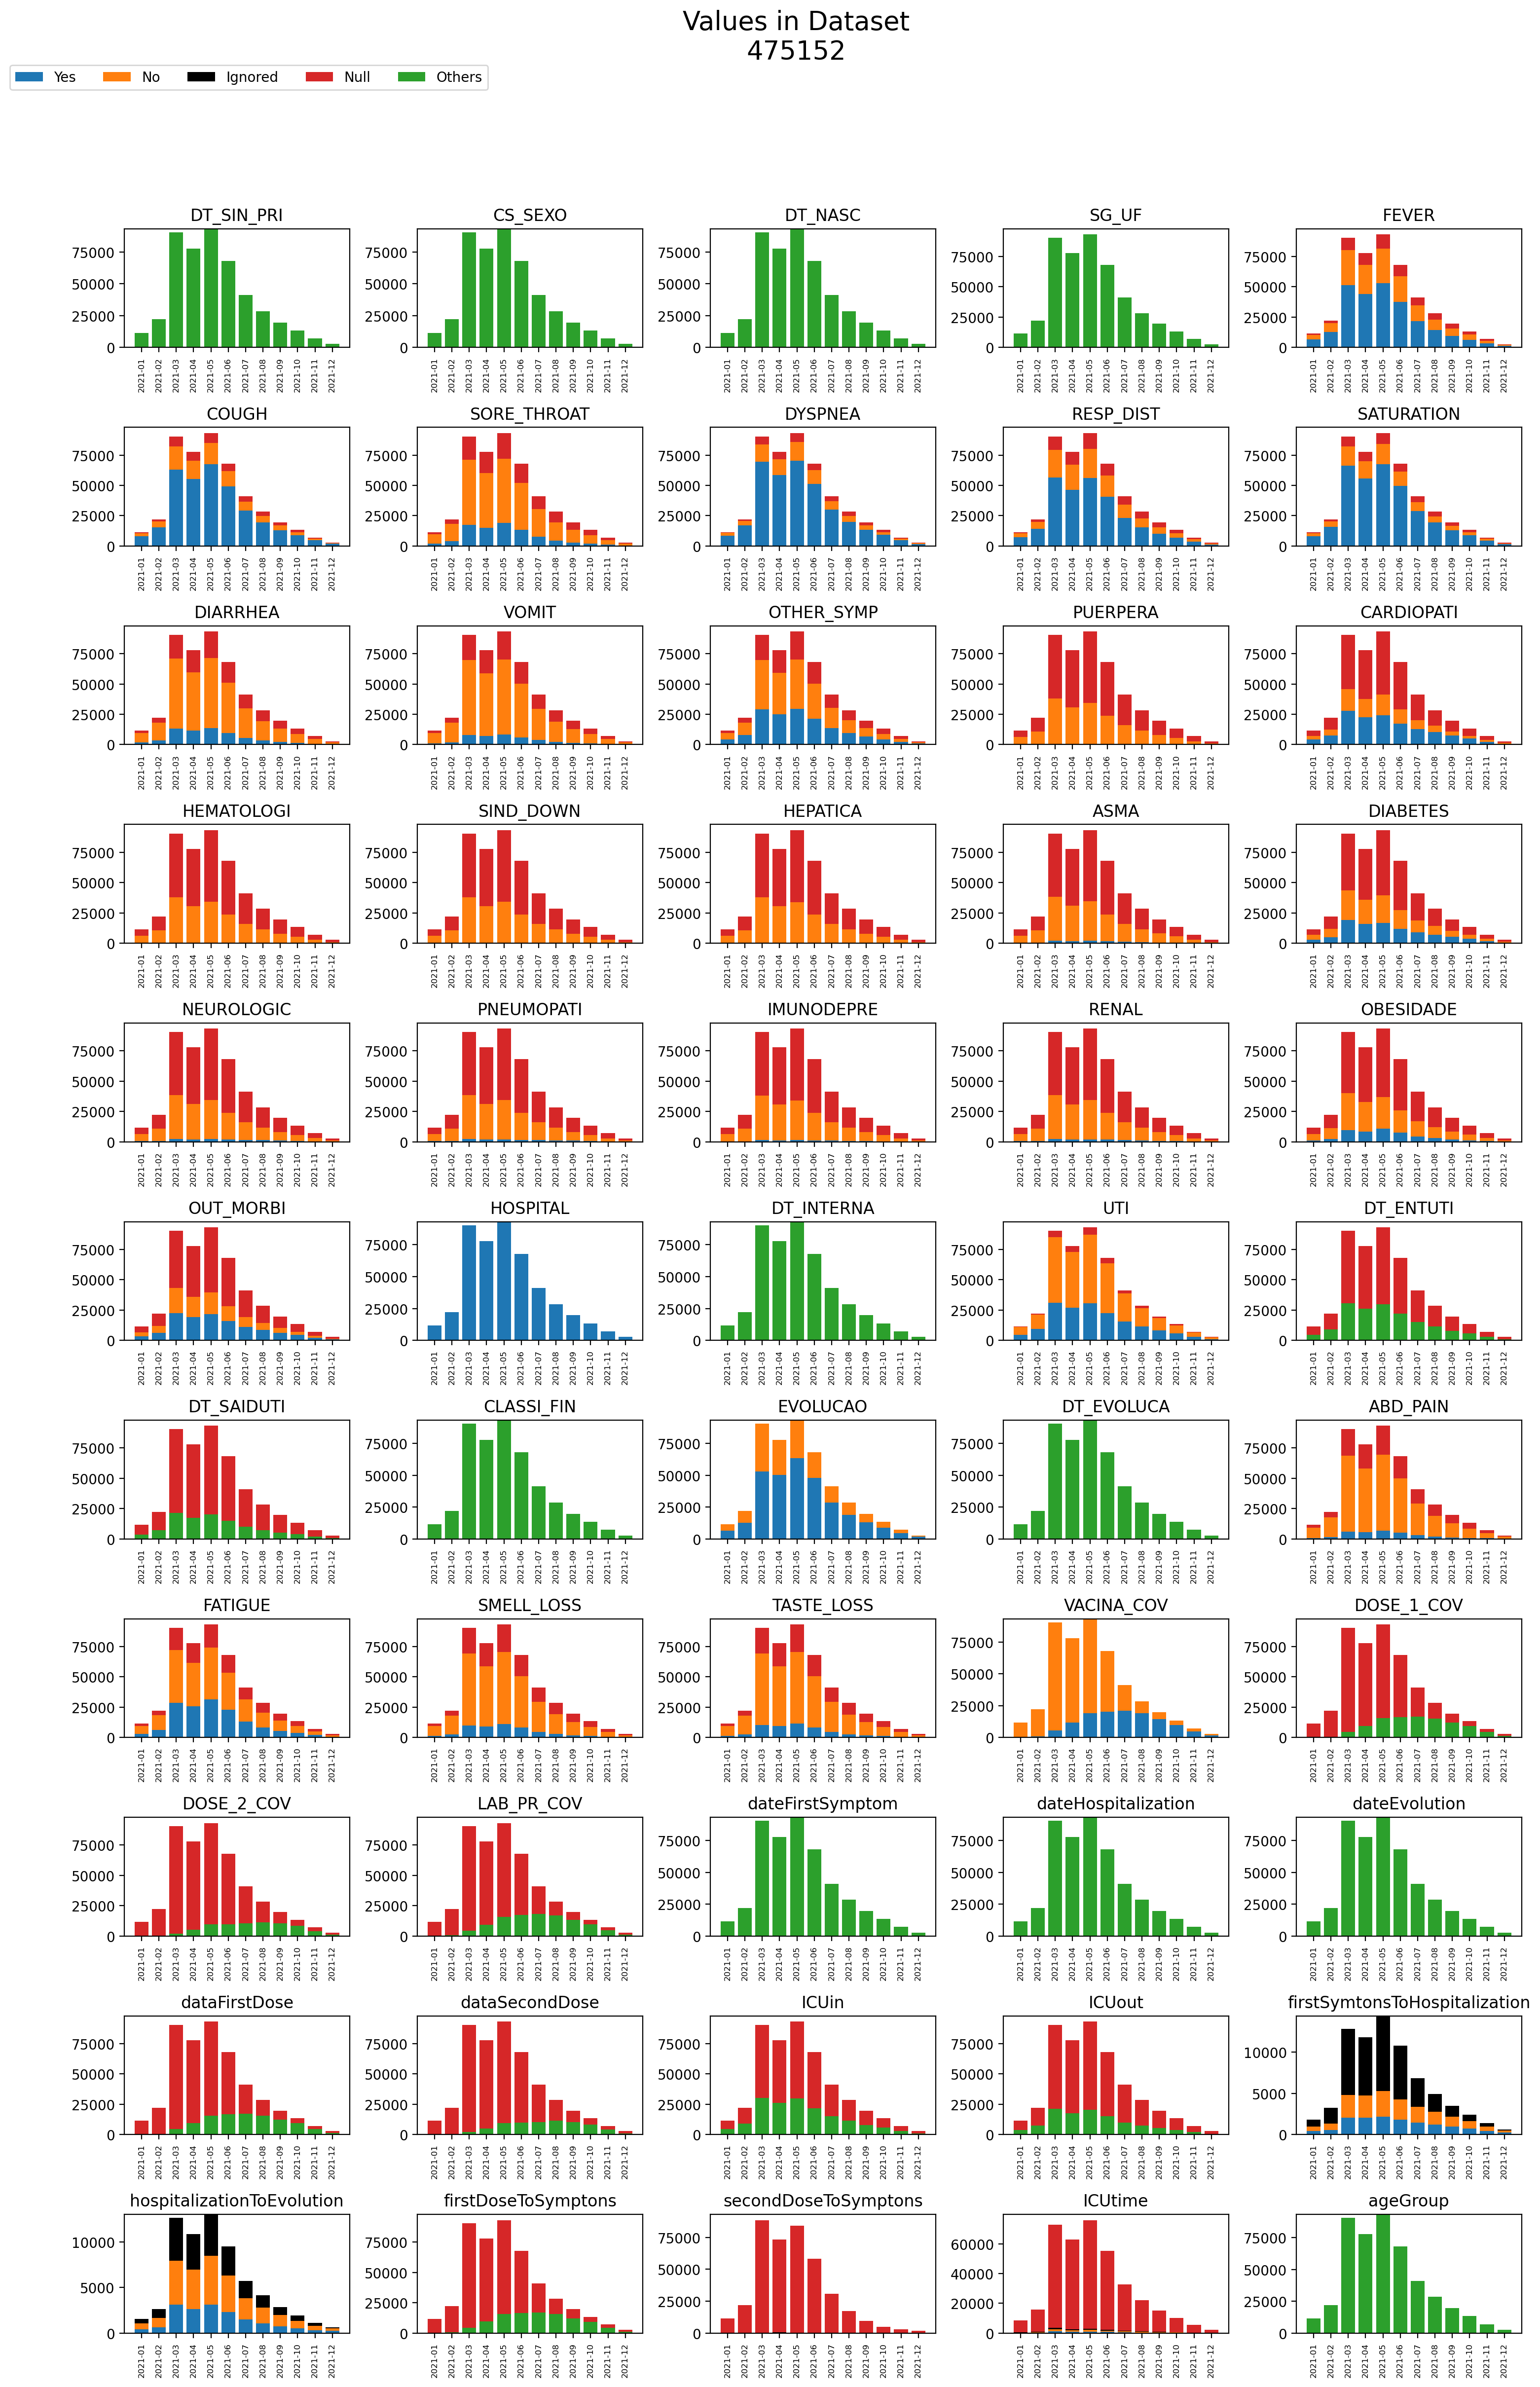

In [29]:
plotDfValues(df_COVID_only)

In [30]:
df_COVID_only.to_csv('covid_2021_FINAL.csv',sep='\t')

In [31]:
df_COVID_only

,DT_SIN_PRI,CS_SEXO,DT_NASC,SG_UF,FEVER,COUGH,SORE_THROAT,DYSPNEA,RESP_DIST,SATURATION,DIARRHEA,VOMIT,OTHER_SYMP,PUERPERA,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OUT_MORBI,HOSPITAL,DT_INTERNA,UTI,DT_ENTUTI,DT_SAIDUTI,CLASSI_FIN,EVOLUCAO,DT_EVOLUCA,ABD_PAIN,FATIGUE,SMELL_LOSS,TASTE_LOSS,VACINA_COV,DOSE_1_COV,DOSE_2_COV,LAB_PR_COV,dateFirstSymptom,dateHospitalization,dateEvolution,yearMonth,ageYearsRoundUp,dataFirstDose,dataSecondDose,ICUin,ICUout,firstSymtonsToHospitalization,hospitalizationToEvolution,firstDoseToSymptons,secondDoseToSymptons,ICUtime,ageGroup
3,09/01/2021,M,17/12/1940,PR,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,11/01/2021,1.0,14/01/2021,18/01/2021,5.0,2.0,18/01/2021,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2021-01-09,2021-01-11,2021-01-18,2021-01,81.0,NaT,NaT,2021-01-14,2021-01-18,2,7,NaN,NaN,4.0,80
12,15/01/2021,F,12/01/1937,PR,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18/01/2021,2.0,NaN,NaN,5.0,1.0,22/01/2021,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2021-01-15,2021-01-18,2021-01-22,2021-01,84.0,NaT,NaT,NaT,NaT,3,4,NaN,NaN,NaN,80
21,03/01/2021,M,16/01/1989,AM,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,15/01/2021,2.0,NaN,NaN,5.0,1.0,22/01/2021,2.0,1.0,1.0,1.0,2.0,NaN,NaN,NaN,2021-01-03,2021-01-15,2021-01-22,2021-01,32.0,NaT,NaT,NaT,NaT,12,7,NaN,NaN,NaN,30
24,10/01/2021,M,19/09/1972,MT,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,19/01/2021,1.0,19/01/2021,26/01/2021,5.0,1.0,30/01/2021,2.0,2.0,2.0,1.0,2.0,NaN,NaN,NaN,2021-01-10,2021-01-19,2021-01-30,2021-01,49.0,NaT,NaT,2021-01-19,2021-01-26,9,11,NaN,NaN,7.0,40
30,14/01/2021,M,01/07/1949,MG,1.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,14/01/2021,2.0,NaN,NaN,5.0,1.0,20/01/2021,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2021-01-14,2021-01-14,2021-01-20,2021-01,72.0,NaT,NaT,NaT,NaT,0,6,NaN,NaN,NaN,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176162,05/11/2021,F,23/01/1949,SP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,1.0,10/11/2021,1.0,10/11/2021,NaN,5.0,2.0,05/12/2021,NaN,NaN,NaN,NaN,1.0,19/03/2021,13/04/2021,86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC,2021-11-05,2021-11-10,2021-12-05,2021-11,72.0,2021-03-19,2021-04-13,2021-11-10,NaT,5,25,231.0,206.0,NaN,70
1176163,19/03/2021,F,20/11/1942,SP,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,19/03/2021,NaN,NaN,NaN,5.0,2.0,20/03/2021,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2021-03-19,2021-03-19,2021-03-20,2021-03,79.0,NaT,NaT,NaT,NaT,0,1,NaN,NaN,NaN,70
1176164,09/03/2021,F,02/04/1949,SP,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,16/03/2021,1.0,16/03/2021,30/03/2021,5.0,2.0,30/03/2021,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2021-03-09,2021-03-16,2021-03-30,2021-03,72.0,NaT,NaT,2021-03-16,2021-03-30,7,14,NaN,NaN,14.0,70
1176165,08/04/2021,M,16/05/1984,PR,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,13/04/2021,1.0,15/04/2021,NaN,5.0,2.0,20/05/2021,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,2021-04-08,2021-04-13,2021-05-20,2021-04,37.0,NaT,NaT,2021-04-15,NaT,5,37,NaN,NaN,NaN,30
